## Notebook 3: Image classifier using CNN

To address our problem statement of building an image classifier to identify 12 classes of hawker food, we will be building two groups of models as follows: 

- Group 1: Own convolutional neural network (CNN) model its respective layers (e.g. Conv2D, MaxPool2D, Dropout, Dense layers)
- Group 2: Transfer learning using pre-trained models (i.e. MobileNetV2, VGG16, ResNet50) for feature extraction and prediction (refer to Notebooks 4-6)

This notebook will be focusing on our Group 1 model.

### 3.1: Importing libraries and setting parameters

In [13]:
#Importing the necessary libraries
import os
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=sys.maxsize)


In [2]:
#Instructing Jupyter notebook to use GPU when running CNN
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')


In [3]:
#Setting out the necessary parameters to train our model
img_width, img_height = 224, 224 
train_data_dir = '../Datasets/Final/Training'
validation_data_dir = '../Datasets/Final/Validation'
test_data_dir= '../Datasets/Final/Test'
batch_size = 128
num_train = 12000
num_validation = 2400

### 3.2: Data augmentation

To prevent any overfitting in our model, we will undertake data augmentation to aritifically created more images out of the exisiting 12,000 training images that we have. Main techniques used include rotation, shifting images upwards/downward or left/right, horizontal flip, zooming in/out at random etc.([*Source: Nanonets*](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/)).



In [4]:
# Data augmentation our 12,000 training images
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                 rotation_range=20,
                 width_shift_range=0.1,
                 height_shift_range=0.1,
                 shear_range=0.1,
                 zoom_range=0.1,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 rescale=1/255)

# Data augmentation our 2,400 validation images (note: only rescale for these images)
val_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255)

# Function that reads images from our designated training path and augmenting the images
# within as per our data augementation parameters above 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Function that reads images from our designated validation path and augmenting the images
# within as per our data augementation parameters above 
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Map index to class names
classes = dict((v, k.replace('_', ' ').title()) for k, v in train_generator.class_indices.items())

Found 12000 images belonging to 12 classes.
Found 2400 images belonging to 12 classes.


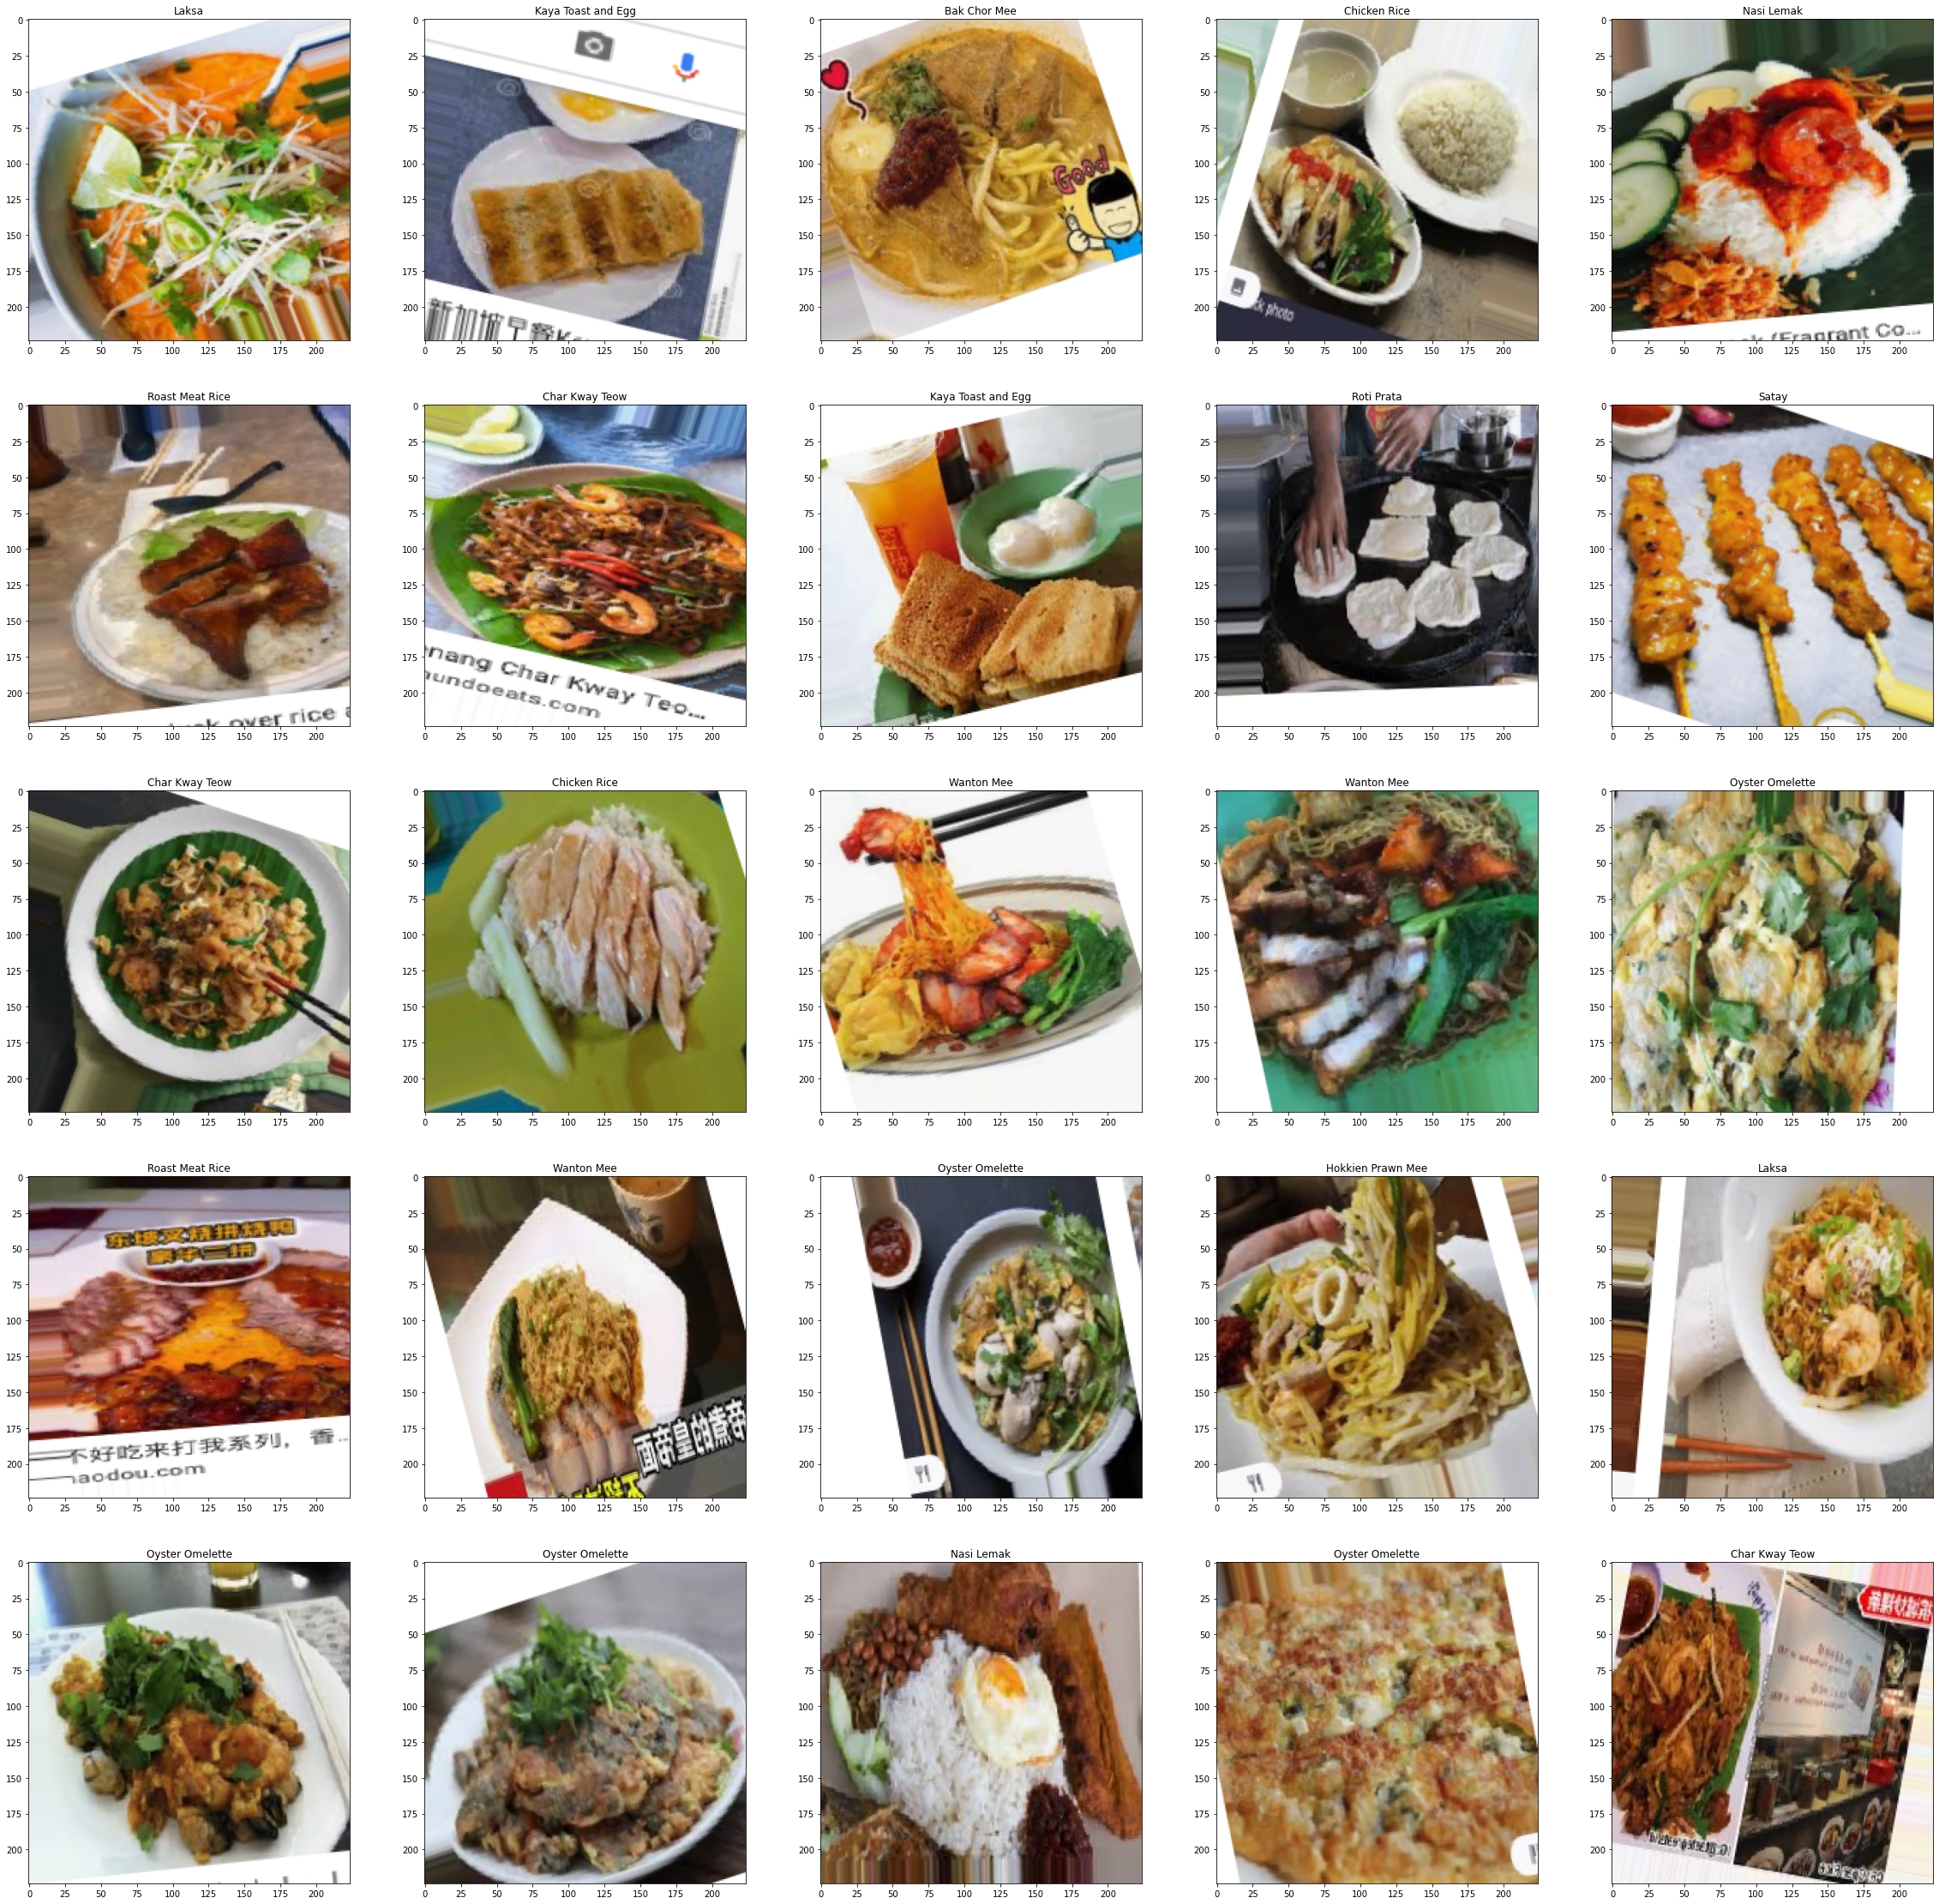

In [5]:
#Preview of images in train_generator
row = 5;column = 5
n=0
classtolabel = {'0':'Bak Chor Mee',"1":'Char Kway Teow', 
                "2":'Chicken Rice', "3":'Hokkien Prawn Mee', "4":'Kaya Toast and Egg', 
                "5":"Laksa", "6": "Nasi Lemak", "7": "Oyster Omelette", "8":"Roast Meat Rice", 
                "9": "Roti Prata", "10":"Satay", "11":"Wanton Mee"}
for x in train_generator:
    fig, axes = plt.subplots(row,column,figsize=(40,40))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

### 3.3: Building our own CNN model

As CNN models are very sensitive to their input parameters, we have tried numerous combinations re data augmentation factors and Conv2D filters/MaxPool2D layers/Dropout rates and their associated input parameters before arriving at the model below.

In [6]:
# Defining our CNN model structure
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (img_width, img_height,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(12, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2()))

### 3.4: Executing our CNN model

In [7]:
# Compiling our CNN model
top3_acc = keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy')
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy', top3_acc])

# Setting our CNN model to train on 100 epochs
epochs = 100

#We also include callbacks that will save the model with the lowest val_loss and 
# also monitor for early stopping re val_loss or reduction of learning rate
filepath=str(os.getcwd()+"/final_model_cnn_1.h5")
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='auto')

# Train model with the relevant callbacks
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    steps_per_epoch=num_train // batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation // batch_size,
    callbacks=[checkpointer, earlystopping,reduceLR])

/Users/Derrick/miniforge3/envs/tf3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/100
93/93 [==============================] - ETA: 0s - batch: 46.0000 - size: 127.6559 - loss: 2.6856 - accuracy: 0.1105 - top_3_categorical_accuracy: 0.3176

/Users/Derrick/miniforge3/envs/tf3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 2.61464, saving model to /Users/Derrick/Documents/DSI-SG-21/Capstone/Notebooks/final_model_cnn_1.h5
93/93 [==============================] - 76s 812ms/step - batch: 46.0000 - size: 127.6559 - loss: 2.6856 - accuracy: 0.1105 - top_3_categorical_accuracy: 0.3176 - val_loss: 2.6146 - val_accuracy: 0.1523 - val_top_3_categorical_accuracy: 0.3806
Epoch 2/100
93/93 [==============================] - ETA: 0s - batch: 46.0000 - size: 127.6559 - loss: 2.5246 - accuracy: 0.1716 - top_3_categorical_accuracy: 0.4407
Epoch 00002: val_loss did not improve from 2.61464
93/93 [==============================] - 72s 782ms/step - batch: 46.0000 - size: 127.6559 - loss: 2.5246 - accuracy: 0.1716 - top_3_categorical_accuracy: 0.4407 - val_loss: 2.6570 - val_accuracy: 0.1567 - val_top_3_categorical_accuracy: 0.4071
Epoch 3/100
93/93 [==============================] - ETA: 0s - batch: 46.0000 - size: 127.6559 - loss: 2.4581 - accuracy: 0.2070 - top_3_categorical_ac

Epoch 17/100
93/93 [==============================] - ETA: 0s - batch: 46.0000 - size: 127.6559 - loss: 1.5990 - accuracy: 0.6022 - top_3_categorical_accuracy: 0.8534
Epoch 00017: val_loss improved from 1.67134 to 1.55190, saving model to /Users/Derrick/Documents/DSI-SG-21/Capstone/Notebooks/final_model_cnn_1.h5
93/93 [==============================] - 72s 783ms/step - batch: 46.0000 - size: 127.6559 - loss: 1.5990 - accuracy: 0.6022 - top_3_categorical_accuracy: 0.8534 - val_loss: 1.5519 - val_accuracy: 0.6059 - val_top_3_categorical_accuracy: 0.8650
Epoch 18/100
93/93 [==============================] - ETA: 0s - batch: 46.0000 - size: 128.0000 - loss: 1.6116 - accuracy: 0.5973 - top_3_categorical_accuracy: 0.8551
Epoch 00018: val_loss did not improve from 1.55190
93/93 [==============================] - 72s 784ms/step - batch: 46.0000 - size: 128.0000 - loss: 1.6116 - accuracy: 0.5973 - top_3_categorical_accuracy: 0.8551 - val_loss: 1.6009 - val_accuracy: 0.5929 - val_top_3_categoric

Epoch 34/100
93/93 [==============================] - ETA: 0s - batch: 46.0000 - size: 127.3118 - loss: 1.3206 - accuracy: 0.7448 - top_3_categorical_accuracy: 0.9289
Epoch 00034: val_loss improved from 1.39165 to 1.36675, saving model to /Users/Derrick/Documents/DSI-SG-21/Capstone/Notebooks/final_model_cnn_1.h5
93/93 [==============================] - 72s 780ms/step - batch: 46.0000 - size: 127.3118 - loss: 1.3206 - accuracy: 0.7448 - top_3_categorical_accuracy: 0.9289 - val_loss: 1.3668 - val_accuracy: 0.7266 - val_top_3_categorical_accuracy: 0.9149
Epoch 35/100
93/93 [==============================] - ETA: 0s - batch: 46.0000 - size: 128.0000 - loss: 1.2989 - accuracy: 0.7492 - top_3_categorical_accuracy: 0.9316
Epoch 00035: val_loss did not improve from 1.36675
93/93 [==============================] - 72s 783ms/step - batch: 46.0000 - size: 128.0000 - loss: 1.2989 - accuracy: 0.7492 - top_3_categorical_accuracy: 0.9316 - val_loss: 1.4237 - val_accuracy: 0.7118 - val_top_3_categoric

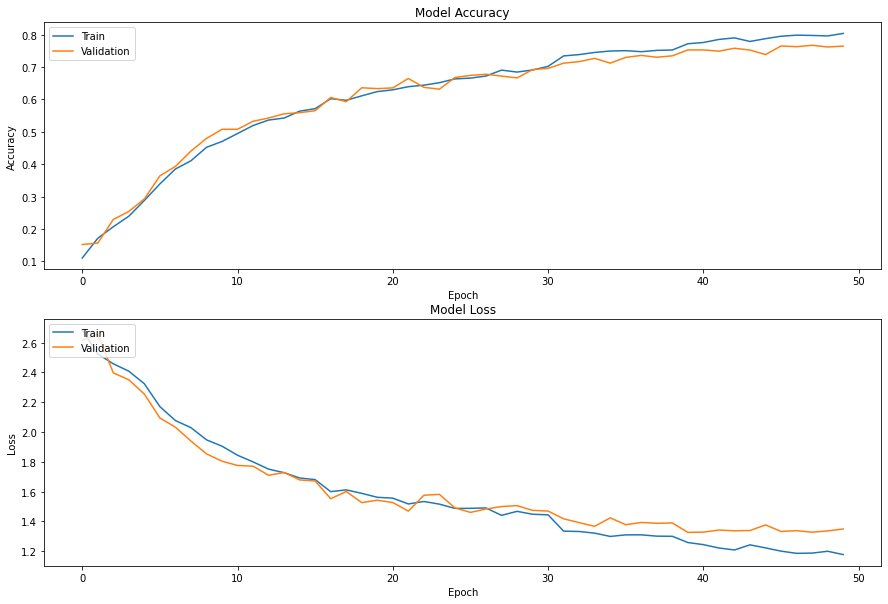

In [8]:
# Defining a simple function to plot the accuracies and losses/val_losses 
# of our training and validation sets

def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
    
plot_hist(history)

Based on the two graphs above, we are satisfied that there is little overfitting/underfitting since our accuracy and val_accuracy lines quite close to each other. Furthermore, both our loss and val_loss lines have a decent convex shape, thereby suggesting minimisation of our loss function and that we have chosen a good learning rate ([*Source: TowardsDataScience*](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10)).

### 3.5: Prediction and evaluation

To prevent data leakage, we will be evaluating our model using our test set which our model has not seen before (i.e. hold-out set). 

In evaluating our model, we will primarily be focusing on its accuracy (i.e. ratio of number of correction predictions to the total number of input images). 

In [9]:
#Setting up our test set for prediction and evaluation
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=2400,
    class_mode='categorical')


Found 2400 images belonging to 12 classes.


In [10]:
#Predicting the labels of our test set using test_generator
x_test, y_test = test_generator.next()
y_pred_conf = model.predict(x_test) 
y_pred = np.argmax(y_pred_conf,axis=1)
y_true = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_true,y_pred)*100))

Accuracy score: 76.4%


Our CNN model yields an accuracy score of 76.4% when evaluated using our test set. This means that 76.4% (or ~1834 out of 2400 test images) are accurately classified into their respective hawker food classes.

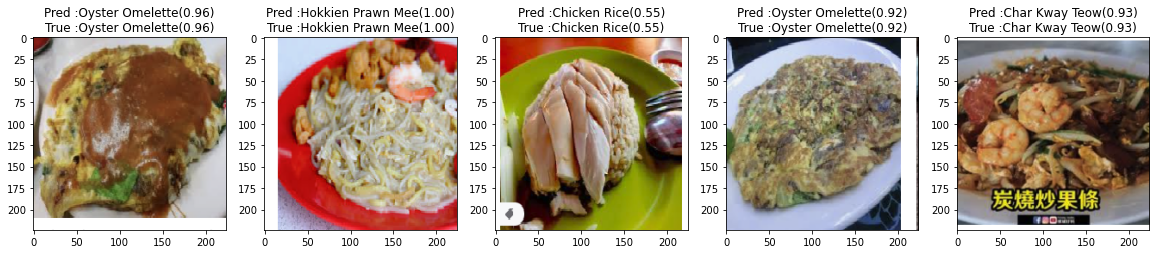

In [11]:
# Printing 5 random images from our test_generator together with their predicted and true labels
ind = np.random.randint(1,len(x_test),5)
fig, axis =plt.subplots(1,5,figsize=(20,10))
for i,j in enumerate(ind):
    axis[i].imshow(x_test[j])
    axis[i].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                          (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                           classtolabel[str(y_true[j])],y_pred_conf[j][(y_true[j])],fontweight="bold", size=20))

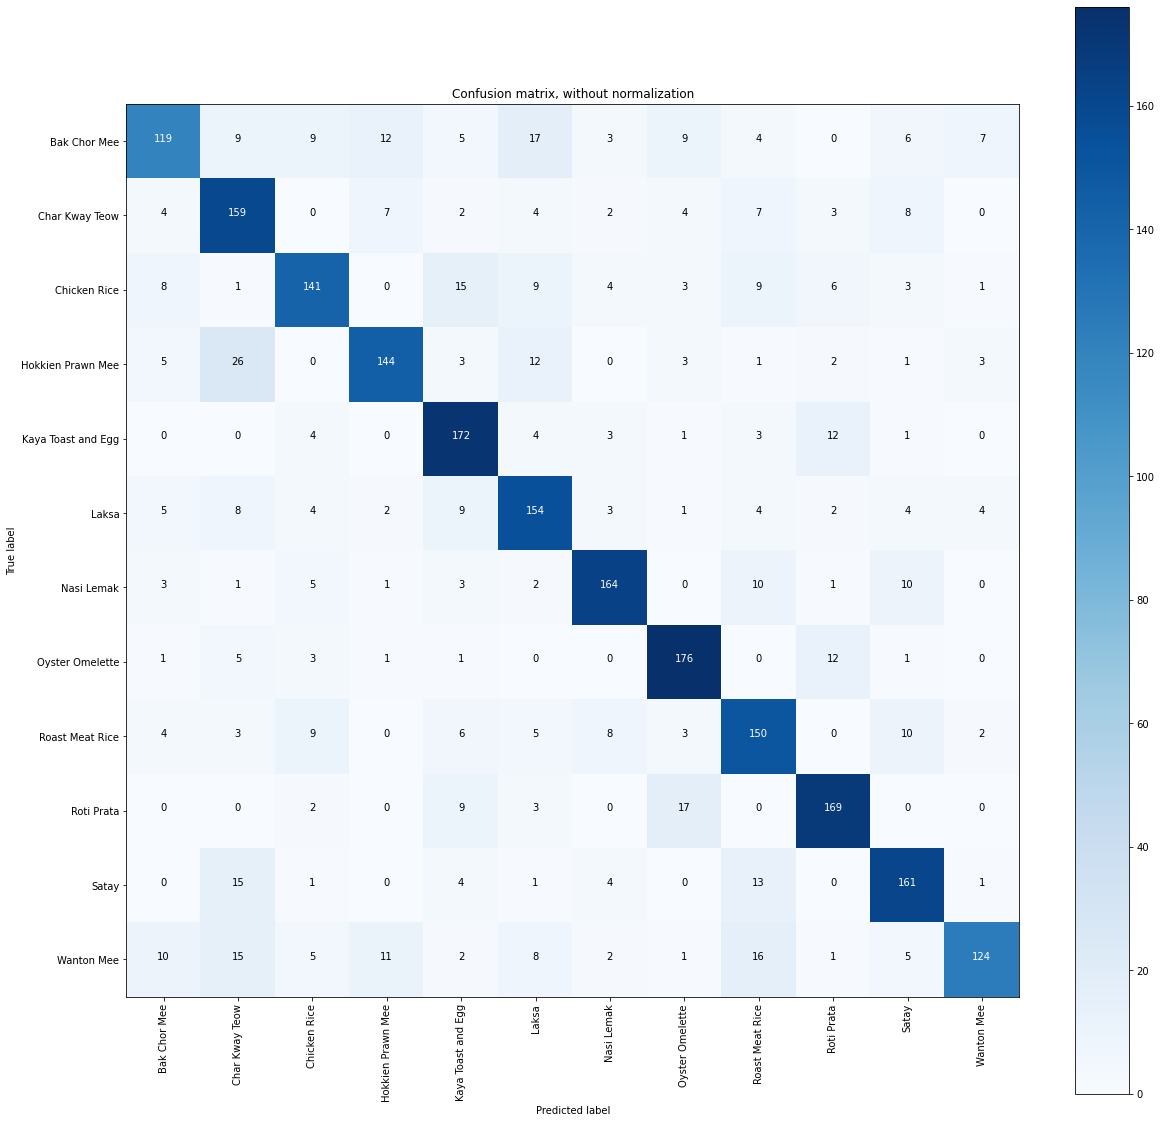

In [18]:
#Defining a function to plot a confusion matrix to see the number of images that we have
#classified accurately and inaccurately

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    classes = ['Bak Chor Mee', 'Char Kway Teow', 
                'Chicken Rice', 'Hokkien Prawn Mee','Kaya Toast and Egg',
               "Laksa", "Nasi Lemak", "Oyster Omelette", "Roast Meat Rice", "Roti Prata", "Satay", "Wanton Mee"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
classes = ['Bak Chor Mee', 'Char Kway Teow', 
                'Chicken Rice', 'Hokkien Prawn Mee','Kaya Toast and Egg',
               "Laksa", "Nasi Lemak", "Oyster Omelette", "Roast Meat Rice", "Roti Prata", "Satay", "Wanton Mee"]

plt.figure(figsize=(20, 20))   
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=classes, title='Confusion matrix, without normalization')


From the confusion matrix above, we can observe that our model is generally good at predicting the correct classes  since Bak Chor Mee (despite having the lowest accuracy amongst all food classes) has 119/200 images correctly classified. 

That said, we noticed that our model tends to struggle with noodle-related images (e.g. 15 Wanton Mee images are inaccurately classified as Char Kway Teow or that 17 Bak Chor Mee images are predicted as Laska). To overcome this and as a possible extension to our project, we can consider collecting and training our CNN model on even more images so that it gets better at recognising and predicting noodle-related images. 